# Benchmark

First, let's load up the fully-trained neural network.

In [1]:
import os
import numpy as np
import logging
import tensorflow as tf
import importlib.util
import sys
import pandas as pd

# Important directories
code_dir = os.path.dirname(os.getcwd())
deep_cal_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Allows to import my own module
sys.path.insert(0, code_dir)

from ann.neural_network import dense_nn
from ann.predict import predict
from ann.helpers import load_labeled_csv

In [2]:
# Logging stuff
logger = logging.getLogger("benchmarking")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(deep_cal_dir + "/code/logs/benchmarking.log")    
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

## Loading the trained network

In [3]:
# NN params
layer_sizes = [64]*4
nb_features = 7
nb_labels = 1

# File directory to saved TF checkpoint files
ckpt_dir = deep_cal_dir + '/data/heston/nn/'

# NN construction
logger.info("Building computational graph of a fully connected neural network.")
nn = dense_nn(nb_features, layer_sizes, nb_labels)
logger.info('Building completed.')

# Restoring weights and biases to NN
logger.info('Starting interactive tensorflow session.')
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(ckpt_dir))
logger.info('Checkpoint loaded. Ready for prediction.')

INFO:tensorflow:Restoring parameters from /Users/stemper/Dropbox/Promotion/projects/deep_calibration/data/heston/nn/final_model


## Input normalisation

The neural network was trained using standardised input data and so weights and biases reflect the scale and offset of that data. To make predictions on unseen test inputs, we hence need to standardise these inputs using the training mean and standard deviation. This standardisation procedure will be encoded in a utility function.

In [4]:
# Training data configuration
train_filename = deep_cal_dir + '/data/heston/training_data.csv'
feature_cols = [ _ for _ in range(7)]
label_cols = [7]

# Extract mean and std from training data
train_tuple = load_labeled_csv(train_filename, feature_cols, label_cols)
train_mean = np.mean(train_tuple.features, axis=0)
train_std = np.std(train_tuple.features, axis=0)

In [5]:
def standardise_inputs(test_inputs, train_mean, train_std):
    
    logger.info("Normalizing input labeled data.")
    
    test_inputs -= train_mean
    test_inputs /= train_std
    
    logger.info('Finished normalization of input data.')
    
    return test_inputs

## Benchmarks




### Timing and accuracy on general test set

In [ ]:
test_filename = deep_cal_dir + '/data/heston/testing_data.csv'

# Import and standardisation of test data
test_tuple = load_labeled_csv(test_filename, feature_cols, label_cols)
test_tuple.features = standardise_inputs(test_tuple.features, train_mean, train_std)

In [ ]:
%timeit test_results = predict(test_tuple.features, nn, sess)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def set_style():

    sns.set_context("paper")

    sns.set(font='serif')
    
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
set_style()
%matplotlib inline

In [ ]:
test_results = predict(test_tuple.features, nn, sess)
absolute_error = np.abs(test_results-test_tuple.labels)
relative_error = absolute_error/test_tuple.labels

In [ ]:
def draw_RE_hist(relative_error):
    
    fig, ax = plt.subplots(1,1)

    ax.hist(relative_error, bins=3000, density=True)
    ax.set_xlabel('Absolute relative error')
    ax.set_ylabel('Frequency density')
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax.set_xlim(0, 0.15)
    # ax.set_ylim(0, 0.03)
    ax.grid(True)

    plt.tight_layout()
    
    fig.savefig('test.pdf')

draw_RE_hist(relative_error)

## Smiles

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def set_style():

    sns.set_context("paper")

    sns.set(font='serif')
    
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
set_style()
%matplotlib inline

Importing smile slice data

In [23]:
filename = deep_cal_dir + '/data/heston/smile_slice_0.04.csv'
# filename = deep_cal_dir + '/data/heston/testing_data.csv'
df = pd.read_csv(filename)
df.head(5)

,lambda,vbar,eta,rho,v0,maturity,moneyness,iv
0,3.3,0.96,2.26,-0.52,0.53,0.04,0.500000,0.704298
1,3.3,0.96,2.26,-0.52,0.53,0.04,0.501001,NaN
2,3.3,0.96,2.26,-0.52,0.53,0.04,0.502002,NaN
3,3.3,0.96,2.26,-0.52,0.53,0.04,0.503003,NaN
4,3.3,0.96,2.26,-0.52,0.53,0.04,0.504004,NaN


In [17]:
df = df[(df.moneyness >= 0.75) & (df.moneyness <=1.1)]

In [18]:
raw_data = df.values.copy()
features = raw_data[:,:7]
labels = raw_data[:,7]
features = standardise_inputs(features, train_mean, train_std)
df.head(5)

,lambda,vbar,eta,rho,v0,maturity,moneyness,iv
250,3.3,0.96,2.26,-0.52,0.53,0.04,0.750250,0.656316
251,3.3,0.96,2.26,-0.52,0.53,0.04,0.751251,0.656450
252,3.3,0.96,2.26,-0.52,0.53,0.04,0.752252,0.656586
253,3.3,0.96,2.26,-0.52,0.53,0.04,0.753253,0.656723
254,3.3,0.96,2.26,-0.52,0.53,0.04,0.754254,0.656862


In [19]:
df['predictions'] = predict(features, nn, sess)
df['absolute_error'] = np.abs(df.predictions-labels)
df['relative_error'] = df.absolute_error/labels

In [20]:
df

,lambda,vbar,eta,rho,v0,maturity,moneyness,iv,predictions,absolute_error,relative_error
250,3.3,0.96,2.26,-0.52,0.53,0.04,0.750250,0.656316,0.640842,0.015475,0.023578
251,3.3,0.96,2.26,-0.52,0.53,0.04,0.751251,0.656450,0.641085,0.015365,0.023407
252,3.3,0.96,2.26,-0.52,0.53,0.04,0.752252,0.656586,0.641383,0.015203,0.023155
253,3.3,0.96,2.26,-0.52,0.53,0.04,0.753253,0.656723,0.641722,0.015001,0.022842
254,3.3,0.96,2.26,-0.52,0.53,0.04,0.754254,0.656862,0.642061,0.014801,0.022533
255,3.3,0.96,2.26,-0.52,0.53,0.04,0.755255,0.657004,0.642405,0.014599,0.022220
256,3.3,0.96,2.26,-0.52,0.53,0.04,0.756256,0.657147,0.642779,0.014367,0.021863
257,3.3,0.96,2.26,-0.52,0.53,0.04,0.757257,0.657292,0.643132,0.014161,0.021544
258,3.3,0.96,2.26,-0.52,0.53,0.04,0.758258,0.657439,0.643484,0.013956,0.021227
259,3.3,0.96,2.26,-0.52,0.53,0.04,0.759259,0.657589,0.643836,0.013753,0.020914


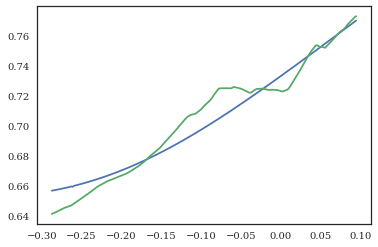

In [21]:
plt.plot(np.log(df.moneyness), df.iv, np.log(df.moneyness), df.predictions)

In [ ]:
df.sort_values('relative_error', ascending=True)

## Surface

In [ ]:
oi_pivot_df = df.pivot(index='time to maturity (years)', 
                           columns='moneyness', values='inv_spread')

    ax = sns.heatmap(oi_pivot_df, cmap="Blues", cbar=True, xticklabels=15, yticklabels=2)
    ax.invert_yaxis()

